In [1]:
# --- Inference & visualization on a specific PDF page (1-based page_number) ---

import math
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# PDF → PIL pages via PyMuPDF (no poppler dependency)
# pip install pymupdf
import fitz  # PyMuPDF

from rfdetr import RFDETRBase

# ----------------------------
# 1) PDF helpers
# ----------------------------
def pdf_to_pil_pages(pdf_path: Path, zoom: float = 2.0):
    """
    Load a PDF and render each page to a PIL.Image at the given zoom.
    Returns: List[PIL.Image]
    """
    assert pdf_path.exists(), f"Missing PDF: {pdf_path}"
    pages = []
    with fitz.open(pdf_path) as doc:
        mat = fitz.Matrix(zoom, zoom)
        for i in range(len(doc)):
            pix = doc[i].get_pixmap(matrix=mat, alpha=False)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            pages.append(img)
    return pages


In [2]:
# ----------------------------
# 2) Drawing & prediction utils
# ----------------------------
def to_numpy(x):
    if x is None: return None
    if hasattr(x, "detach"): return x.detach().cpu().numpy()
    if hasattr(x, "cpu"):    return x.cpu().numpy()
    return np.asarray(x)

def draw_rect(draw: ImageDraw.Draw, box, color=(255, 0, 0), width=3):
    x1, y1, x2, y2 = map(int, box)
    for t in range(width):
        draw.rectangle([x1 - t, y1 - t, x2 + t, y2 + t], outline=color)

def parse_preds(pred):
    """
    Normalize various RF-DETR predict() outputs to numpy arrays:
    returns (xyxy[N,4], scores[N], labels[N]) as np arrays.
    """
    try:
        import supervision as sv
        if isinstance(pred, sv.Detections):
            xyxy   = pred.xyxy
            scores = pred.confidence if pred.confidence is not None else np.ones((len(pred),), dtype=float)
            labels = pred.class_id   if pred.class_id   is not None else np.zeros((len(pred),), dtype=int)
            return xyxy, scores, labels
    except Exception:
        pass

    if isinstance(pred, list) and len(pred) > 0:
        pred = pred[0]

    if isinstance(pred, dict):
        xyxy   = to_numpy(pred.get("boxes"))  or np.zeros((0, 4), dtype=float)
        scores = to_numpy(pred.get("scores")) or np.ones((xyxy.shape[0],), dtype=float)
        labels = to_numpy(pred.get("labels")) or np.zeros((xyxy.shape[0],), dtype=int)
        return xyxy, scores, labels

    # Unknown → empty
    return np.zeros((0, 4), dtype=float), np.zeros((0,), dtype=float), np.zeros((0,), dtype=int)


In [3]:
# ----------------------------
# 3) Main: run on a given PDF page
# ----------------------------
def run_pdf_page_inference(
    pdf_path: Path,
    page_number: int,          # 1-based
    ckpt_path: Path,
    conf_th: float = 0.5,
    zoom: float = 2.0,
    show: bool = True,
):
    """
    Loads PDF → list of PIL pages, runs RF-DETR on the selected page_number,
    and visualizes predictions (red boxes + scores).
    """
    # Load pages
    pages = pdf_to_pil_pages(pdf_path, zoom=zoom)
    assert len(pages) > 0, f"No pages found in {pdf_path}"
    assert 1 <= page_number <= len(pages), f"page_number must be in [1, {len(pages)}]"
    img = pages[page_number - 1]
    W, H = img.size

    # Load model
    assert ckpt_path.exists(), f"Missing checkpoint: {ckpt_path}"
    model = RFDETRBase(pretrain_weights=str(ckpt_path))
    try:
        model.optimize_for_inference()
    except Exception:
        pass

    # Predict (filter later to be robust to API variants)
    raw = model.predict(img, threshold=conf_th)
    pred_xyxy, pred_scores, pred_labels = parse_preds(raw)
    if pred_scores.size > 0:
        keep = pred_scores >= conf_th
        pred_xyxy   = pred_xyxy[keep]
        pred_scores = pred_scores[keep]
        pred_labels = pred_labels[keep]

    # OPTIONAL: If you have GT for this PDF page, provide it here:
    # gt_xyxy = np.array([...], dtype=np.float32)  # or leave empty:
    gt_xyxy = np.zeros((0, 4), dtype=np.float32)

    # Print brief info
    def fmt(b): return f"[{b[0]:.1f},{b[1]:.1f},{b[2]:.1f},{b[3]:.1f}]"
    print(f"\nPDF: {pdf_path.name}  page={page_number}/{len(pages)}  size=({W}x{H})  "
          f"GT={len(gt_xyxy)}  Pred(≥{conf_th})={len(pred_xyxy)}")
    for j in range(min(2, len(pred_xyxy))):
        print(f"  Pred[{j}] xyxy={fmt(pred_xyxy[j])}  score={float(pred_scores[j]):.2f}")

    # Draw overlay
    vis = img.copy()
    draw = ImageDraw.Draw(vis)

    # GT (green) if present
    for box in gt_xyxy:
        draw_rect(draw, box, color=(0, 255, 0), width=3)

    # Pred (red)
    for box, s in zip(pred_xyxy, pred_scores):
        draw_rect(draw, box, color=(255, 0, 0), width=3)
        x1, y1, _, _ = map(int, box)
        draw.text((x1, max(0, y1 - 14)), f"{s:.2f}", fill=(255, 0, 0))

    if show:
        plt.figure(figsize=(10, 10))
        plt.title(f"{pdf_path.name} • page {page_number}/{len(pages)} • ({W}x{H}) • Pred: {len(pred_xyxy)} (≥{conf_th})")
        plt.imshow(vis)
        plt.axis("off")
        plt.show()

    return pages, vis, (pred_xyxy, pred_scores, pred_labels)

Loading pretrain weights


num_classes mismatch: pretrain weights has 0 classes, but your model has 90 classes
reinitializing detection head with 0 classes



PDF: sample_drawings.pdf  page=4/39  size=(1584x1224)  GT=0  Pred(≥0.5)=6
  Pred[0] xyxy=[926.5,403.4,981.6,413.6]  score=0.73
  Pred[1] xyxy=[240.2,718.6,328.6,732.3]  score=0.68


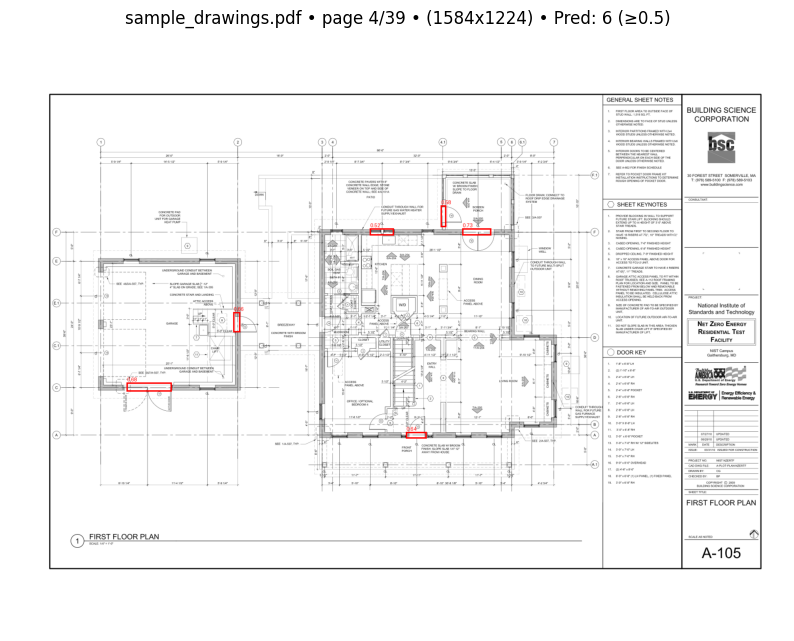

Loaded 39 pages from sample_drawings.pdf


In [ ]:

pdf_path  = Path("sample_drawings.pdf")                       # <- set your PDF
ckpt_path = Path("outputs_10_epochs/checkpoint_best_ema.pth")  # <- your trained checkpoint

Loading pretrain weights


num_classes mismatch: pretrain weights has 0 classes, but your model has 90 classes
reinitializing detection head with 0 classes



PDF: sample_drawings.pdf  page=4/39  size=(1584x1224)  GT=0  Pred(≥0.3)=6
  Pred[0] xyxy=[926.5,403.4,981.6,413.6]  score=0.73
  Pred[1] xyxy=[240.2,718.6,328.6,732.3]  score=0.68


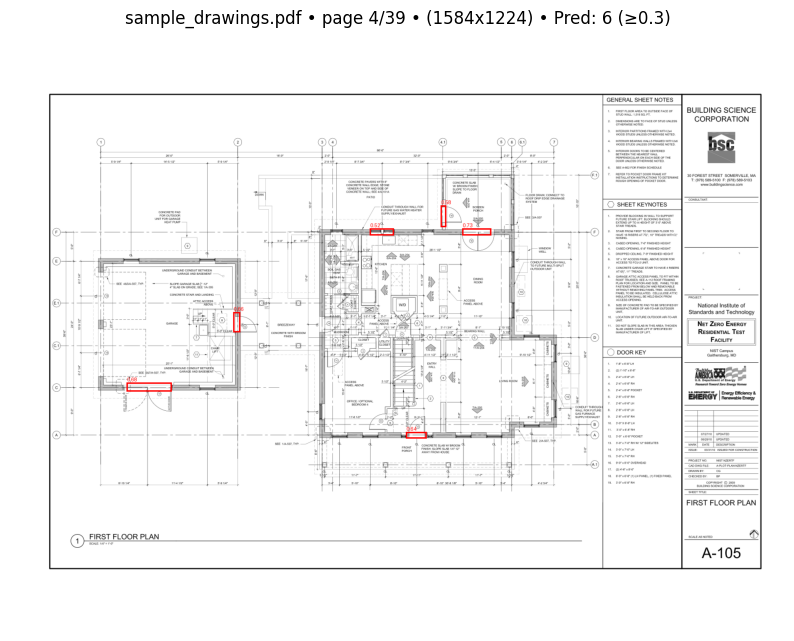

Loaded 39 pages from sample_drawings.pdf


In [8]:
page_no   = 4   # 1-based

pages, vis_img, preds = run_pdf_page_inference(
    pdf_path=pdf_path,
    page_number=page_no,
    ckpt_path=ckpt_path,
    conf_th=0.3,
    zoom=2.0,   # increase for sharper render
    show=True,
)

# pages is a list of PIL images for all PDF pages
print(f"Loaded {len(pages)} pages from {pdf_path}")